# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-03-18 19:35:48--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-03-18 19:35:48--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        output = [
            "Average loss: %f" % ave_loss,
            "Train accuracy: %f" % train_accuracy,
            "Val accuracy: %f" % val_accuracy
        ]
        
        if scheduler:
            output.append("Learning rate: {}".format(scheduler.get_lr()))
            
        print(", ".join(output))
        
        if scheduler:
            scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode

    total_hits_count = 0
    total_inputs_count = 0
    
    for x, y in loader:
      x_gpu = x.to(device)
      y_gpu = y.to(device)

      prediction = model(x_gpu)

      prediction = model(x_gpu)
      probs = torch.argmax(prediction.data, axis=1)
      
      total_hits_count += (probs == y_gpu).sum().item()
      total_inputs_count += x_gpu.shape[0]
    
    return total_hits_count / total_inputs_count if total_inputs_count > 0 else 0.0

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.419086, Train accuracy: 0.524759, Val accuracy: 0.732988
Average loss: 0.702837, Train accuracy: 0.785807, Val accuracy: 0.802061
Average loss: 0.596769, Train accuracy: 0.821093, Val accuracy: 0.808136
Average loss: 0.549695, Train accuracy: 0.836058, Val accuracy: 0.841649
Average loss: 0.516416, Train accuracy: 0.846756, Val accuracy: 0.827930


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

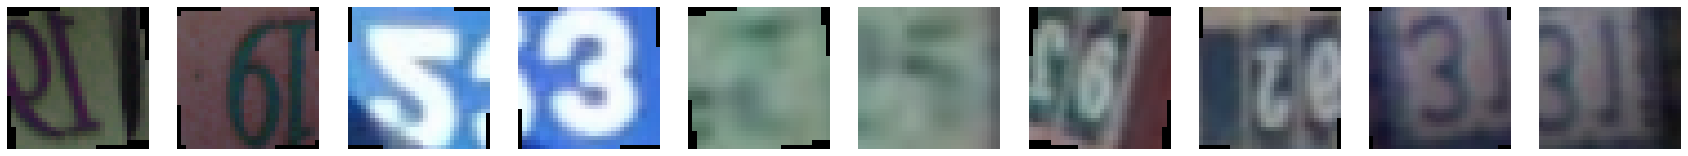

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=0.2, saturation=.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=0.2, saturation=.2),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.590785, Train accuracy: 0.818227, Val accuracy: 0.831752
Average loss: 0.555333, Train accuracy: 0.831673, Val accuracy: 0.849567
Average loss: 0.531672, Train accuracy: 0.839163, Val accuracy: 0.830182
Average loss: 0.518761, Train accuracy: 0.842030, Val accuracy: 0.839533
Average loss: 0.505930, Train accuracy: 0.847217, Val accuracy: 0.850590


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            Flattener(),
            nn.Linear(16 * 6 * 6, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.957739, Train accuracy: 0.696465, Val accuracy: 0.840762
Average loss: 0.551307, Train accuracy: 0.832338, Val accuracy: 0.849430
Average loss: 0.508529, Train accuracy: 0.846040, Val accuracy: 0.845881
Average loss: 0.488551, Train accuracy: 0.852899, Val accuracy: 0.858098
Average loss: 0.474225, Train accuracy: 0.857660, Val accuracy: 0.855163
Average loss: 0.465750, Train accuracy: 0.859246, Val accuracy: 0.861784
Average loss: 0.458982, Train accuracy: 0.862164, Val accuracy: 0.868883
Average loss: 0.457746, Train accuracy: 0.862113, Val accuracy: 0.867995
Average loss: 0.451237, Train accuracy: 0.863615, Val accuracy: 0.873046
Average loss: 0.451504, Train accuracy: 0.864775, Val accuracy: 0.872500


# Подбор гиперпараметров

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
import itertools

RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])


class GridSearchIterator:
  def __init__(self, hparams):
    self.Hyperparams = namedtuple("Hyperparams", list(hparams.keys()))
    self.__combinations = list(itertools.product(*(hparams.values())))
    self.__index = 0
    self.__keys = list(hparams.keys())

  def __next__(self):
    if self.__index >= len(self.__combinations):
      raise StopIteration
    
    hparams = self.__combinations[self.__index]
    hparams = { key: value for (key, value) in zip(self.__keys, hparams) }
    self.__index += 1
    return self.Hyperparams(**hparams)


class GridSearch:
  def __init__(self, **kwargs):
    self.parameters = kwargs
  
  def __iter__(self):
    return GridSearchIterator(self.parameters)


def grid_search_train(train_lambda, grid_search, metric):
  results = []
  for hparams in grid_search:
    print("Executing with hparams: {}".format(hparams))
    run_result = train_lambda(hparams)
    results.append((hparams, run_result))
  
  best_result = max(results, key=lambda x: getattr(x[1], metric))
  print("Best hyper parameters: {}".format(best_result[0]))
  print("Best run result: {}".format(best_result[1]))
  return best_result[0], best_result[1]

In [21]:
def train_lenet(hparams):
  global data_aug_train, train_sampler, val_loader

  learning_rate = hparams.learning_rate
  step_size = hparams.scheduler_step_size
  gamma = hparams.scheduler_gamma
  reg = hparams.reg
  batch_size = hparams.batch_size
  epoch_num = hparams.epoch_num

  train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

  lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            Flattener(),
            nn.Linear(16 * 6 * 6, 10),
          )
  
  lenet_model.type(torch.cuda.FloatTensor)
  lenet_model.to(device)

  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=reg)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

  return RunResult(model=lenet_model, train_history=train_history, val_history=val_history, final_val_accuracy=val_history[-1])
  

grid_search = GridSearch(
    learning_rate=[1e-1, 75e-3, 5e-2],
    scheduler_gamma=[0.5],
    scheduler_step_size=[2, 4],
    reg=[1e-4],
    batch_size=[64],
    epoch_num=[10]
)

best_hyperparams, best_run_result = grid_search_train(train_lenet, grid_search, 'final_val_accuracy')

best_val_accuracy = best_run_result.final_val_accuracy
best_run = best_run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Executing with hparams: Hyperparams(learning_rate=0.1, scheduler_gamma=0.5, scheduler_step_size=2, reg=0.0001, batch_size=64, epoch_num=10)
Average loss: 0.966191, Train accuracy: 0.692796, Val accuracy: 0.840079, Learning rate: [0.1]
Average loss: 0.546137, Train accuracy: 0.834642, Val accuracy: 0.854890, Learning rate: [0.1]
Average loss: 0.482264, Train accuracy: 0.856312, Val accuracy: 0.865265, Learning rate: [0.025]
Average loss: 0.465357, Train accuracy: 0.862608, Val accuracy: 0.871340, Learning rate: [0.05]
Average loss: 0.443756, Train accuracy: 0.868938, Val accuracy: 0.880691, Learning rate: [0.0125]
Average loss: 0.437061, Train accuracy: 0.870201, Val accuracy: 0.878711, Learning rate: [0.025]
Average loss: 0.428151, Train accuracy: 0.872129, Val accuracy: 0.881237, Learning rate: [0.00625]
Average loss: 0.424372, Train accuracy: 0.874040, Val accuracy: 0.881237, Learning rate: [0.0125]
Average loss: 0.421856, Train accuracy: 0.876020, Val accuracy: 0.884240, Learning ra

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [24]:
def train_best_model(hparams):
  global data_aug_train, train_sampler, val_loader

  learning_rate = hparams.learning_rate
  step_size = hparams.scheduler_step_size
  gamma = hparams.scheduler_gamma
  reg = hparams.reg
  batch_size = hparams.batch_size
  epoch_num = hparams.epoch_num

  train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

  lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=16, eps=1e-5, momentum=1e-1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            Flattener(),

            nn.Linear(64 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),

            nn.Linear(128, 10)
          )
  
  lenet_model.type(torch.cuda.FloatTensor)
  lenet_model.to(device)

  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=reg)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

  return RunResult(model=lenet_model, train_history=train_history, val_history=val_history, final_val_accuracy=val_history[-1])
  

grid_search = GridSearch(
    learning_rate=[2e-1, 1e-1, 5e-2],
    scheduler_gamma=[0.5],
    scheduler_step_size=[5, 10],
    reg=[1e-4],
    batch_size=[64],
    epoch_num=[15]
)

best_hyperparams, best_run_result = grid_search_train(train_best_model, grid_search, 'final_val_accuracy')

best_val_accuracy = best_run_result.final_val_accuracy
best_run = best_run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Executing with hparams: Hyperparams(learning_rate=0.1, scheduler_gamma=0.5, scheduler_step_size=10, reg=0.0001, batch_size=64, epoch_num=15)
Average loss: 0.629271, Train accuracy: 0.803450, Val accuracy: 0.889223, Learning rate: [0.1]
Average loss: 0.387454, Train accuracy: 0.881360, Val accuracy: 0.897618, Learning rate: [0.1]
Average loss: 0.327814, Train accuracy: 0.900915, Val accuracy: 0.911474, Learning rate: [0.1]
Average loss: 0.292108, Train accuracy: 0.911920, Val accuracy: 0.913385, Learning rate: [0.1]
Average loss: 0.268787, Train accuracy: 0.917892, Val accuracy: 0.918777, Learning rate: [0.1]
Average loss: 0.246840, Train accuracy: 0.926151, Val accuracy: 0.926558, Learning rate: [0.1]
Average loss: 0.231343, Train accuracy: 0.929478, Val accuracy: 0.923486, Learning rate: [0.1]
Average loss: 0.215221, Train accuracy: 0.934563, Val accuracy: 0.924920, Learning rate: [0.1]
Average loss: 0.201692, Train accuracy: 0.939392, Val accuracy: 0.926490, Learning rate: [0.1]
Aver

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [26]:
best_model = best_run.model

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9217117393976644
